## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 2)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11
bova11_copy = bova11.copy()

In [4]:
len(bova11)

3497

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3399,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3400,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0
3401,2023-01-31 00:00:00-03:00,108.709999,109.959999,108.709999,109.839996,5733562,0,0
3402,2023-02-01 00:00:00-03:00,109.489998,109.860001,107.059998,108.400002,10380157,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3404/3404 [00:00<00:00, 8385.56it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

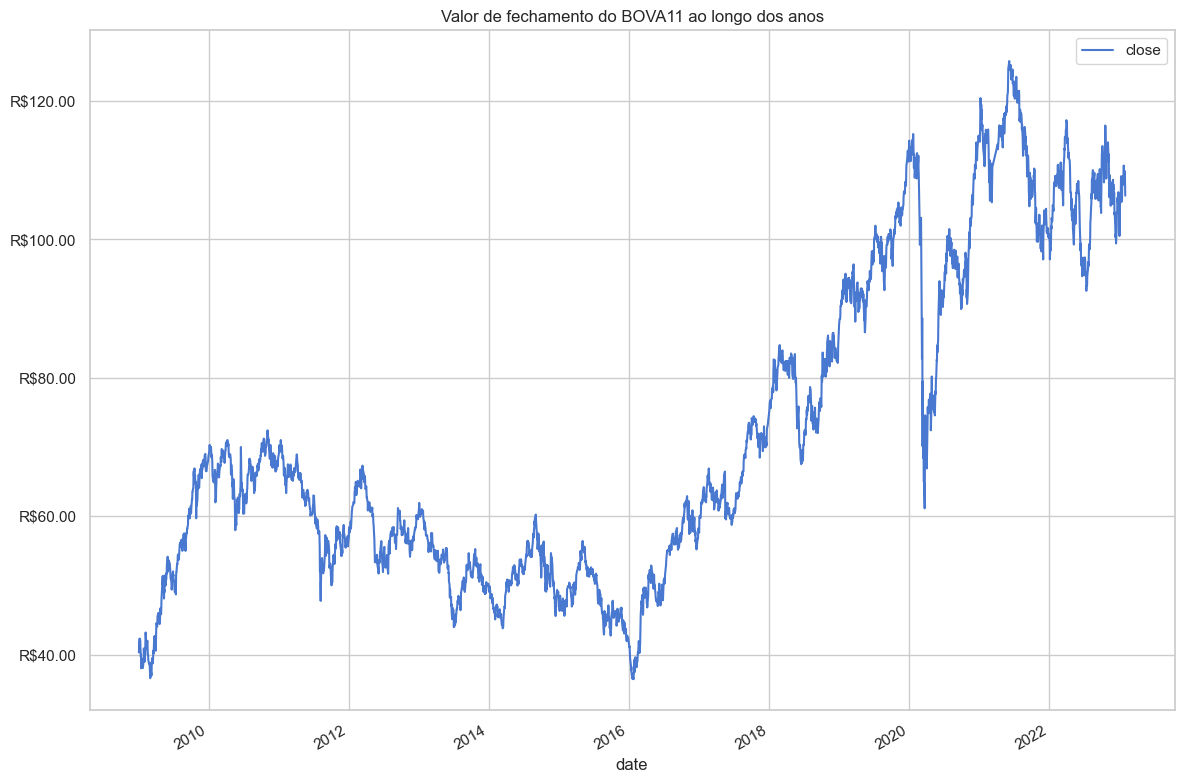

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

In [18]:
# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

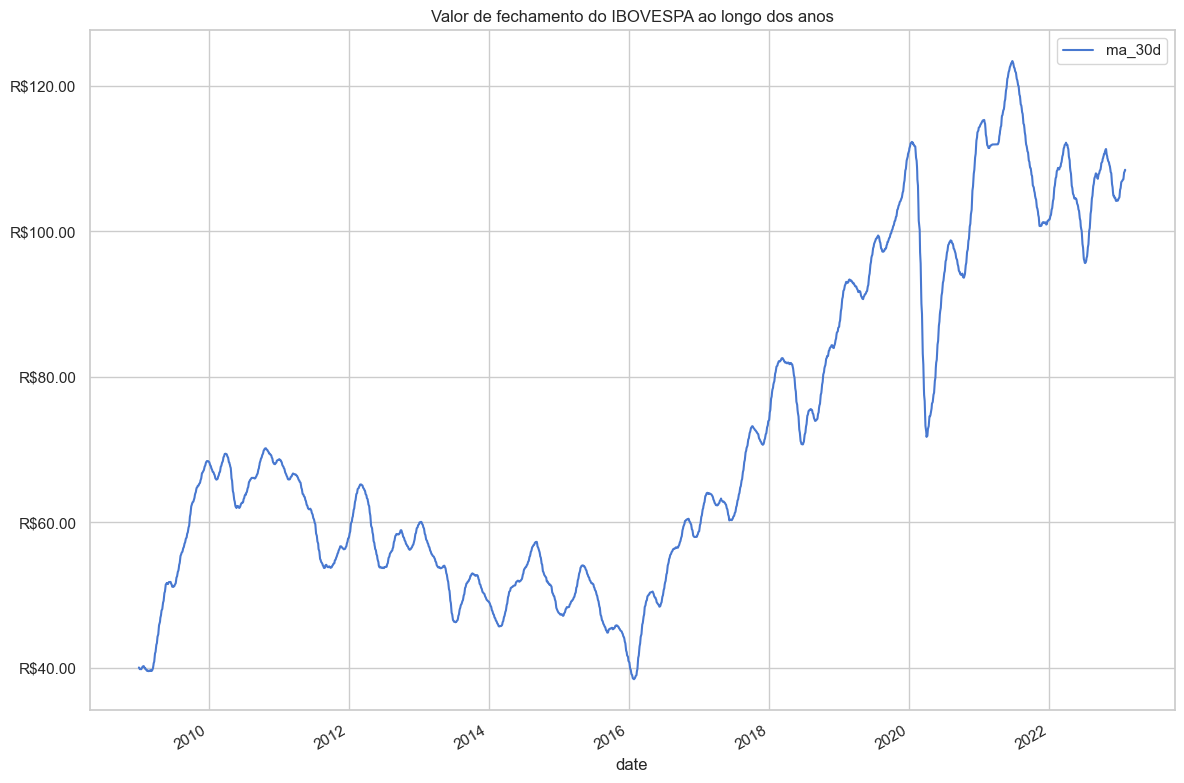

In [19]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [20]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [21]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,1.546823,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,1.459856,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609
3401,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,1.319171,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912
3402,109.489998,109.860001,107.059998,108.400002,-1.439995,108.180000,108.958571,108.465294,106.605938,1.279419,1.323428,2.543337,111.740443,104.619557,111.112150,105.818438,111.692613,101.519263,52.870335


In [22]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [23]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,...,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845,-1.879997,108.699997
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,...,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609,-0.310005,109.839996
3401,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,...,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912,1.129997,108.400002
3402,109.489998,109.860001,107.059998,108.400002,-1.439995,108.180000,108.958571,108.465294,106.605938,1.279419,...,2.543337,111.740443,104.619557,111.112150,105.818438,111.692613,101.519263,52.870335,-1.089996,106.300003


In [24]:
bova11.dropna(inplace = True)

In [25]:
#bova11.drop(axis = 1, columns = ['open', 'high', 'low'] , inplace = True)

In [26]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.73624277  0.62280992  0.62733194 ...  0.1831316  -0.85119142
   0.64367293]
 [ 0.73146451  0.63709403  0.64036862 ...  0.26982232 -0.81106316
   0.6114222 ]
 [ 0.74388784  0.63486217  0.6032816  ...  0.13341511 -0.87292727
   0.56438976]]


Select the features and prediction target columns

In [27]:
backcandles = 100
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3288, 100, 19), (3288, 1))

Split the train and test data

In [28]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [29]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2959, 100, 19) (328, 100, 19) (2959, 1) (328, 1)


### 4. Creating the model

In [30]:
def create_gru_model(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(GRU(64, input_shape = (backcandles, num_features)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [31]:
model = create_gru_model(100, 19, 0.1)
model.fit(x = X_train, y = y_train, batch_size = 16, epochs = 10, shuffle = True, validation_split = 0.1)

Epoch 1/10
167/167 [==============================] - 19s 82ms/step - loss: 0.0082 - val_loss: 0.0018
Epoch 2/10
167/167 [==============================] - 13s 77ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 3/10
167/167 [==============================] - 16s 97ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 4/10
167/167 [==============================] - 14s 86ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/10
167/167 [==============================] - 14s 82ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/10
167/167 [==============================] - 13s 79ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/10
167/167 [==============================] - 13s 79ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/10
167/167 [==============================] - 14s 82ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/10
167/167 [==============================] - 14s 81ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/10
167/167 [==============================] - 12s 69ms/step - loss: 0.001

In [32]:
results = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 25ms/step - loss: 0.0017


### 5. Making predictions

In [33]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 1s 21ms/step
[0.57898015] [0.63023511]
[0.56983906] [0.62418815]
[0.58439225] [0.65218367]
[0.5833047] [0.64613655]
[0.587442] [0.57558797]
[0.5578927] [0.57402023]
[0.5094081] [0.50503922]
[0.50584346] [0.47547596]
[0.47581252] [0.52519603]
[0.47725824] [0.47368421]


In [34]:
y_pred.shape

(328, 1)

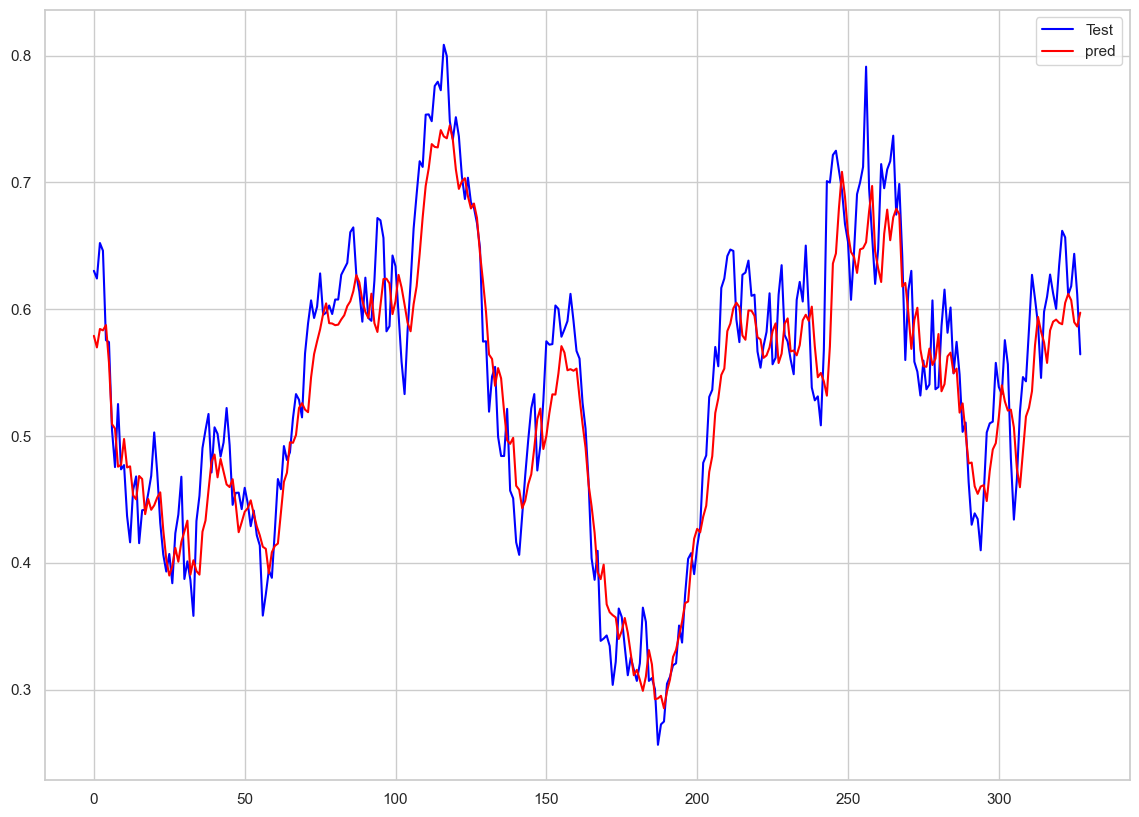

In [35]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [36]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [37]:
MAPE(y_test, y_pred)

6.148489902714839

In [38]:
MAE(y_test, y_pred)

0.033231641251717764

In [39]:
RMSE(y_test, y_pred)

0.040895712044227935

In [40]:
backcandles = 50
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))
    
splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

### 7. Tuning the hyperparameters

In [41]:
def GRU_hyperparameter_tuning(config):
    first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = config
    combinations = list(itertools.product(first_add_layer, second_add_layer, third_add_layer,
                                         n_neurons, n_batch_size, dropout, pass_days))
    print(combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(combinations)):
        
        print(f'{i+1}th combination: \n')
        print('-'* 100)
        
        first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = combinations[i]
        
        print(combinations[i])
        
        backcandles = pass_days
        X = []
        for j in range(19): # range is the number of feature columns you will use
            X.append([])
            for k in range(backcandles, bova11_scaled.shape[0]):
                X[j].append(bova11_scaled[k-backcandles:k, j])

        #move axis from 0 to position 2
        X = np.moveaxis(X, [0], [2])

        X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
        y = np.reshape(yi, (len(yi), 1))

        splitlimit = int(len(X) * 0.9)
        x_train, x_test = X[:splitlimit], X[splitlimit+1:]
        y_train, y_test = y[:splitlimit], y[splitlimit+1:]
        
        model = Sequential()
        model.add(GRU(units = n_neurons, return_sequences = True,
                 input_shape = (x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(dropout))
        
        if first_add_layer:
            model.add(GRU(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if second_add_layer:
            model.add(GRU(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if third_add_layer:
            model.add(GRU(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        model.add(GRU(units = n_neurons, return_sequences = False))
        model.add(Dropout(dropout))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(optimizer = 'adam', 
                      loss = 'mse', 
                      metrics = [tf.keras.metrics.RootMeanSquaredError()])
        
        es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)
        
        file_path = 'best_model.h5'
        
        mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)
        
        model.fit(x_train, y_train, 
                  validation_split = 0.1, 
                  epochs = 50, 
                  batch_size = n_batch_size,
                  callbacks = [es, mc], 
                  verbose = 0,
                  shuffle = True)
        train_accuracy = model.evaluate(x_train, y_train, verbose = 0)
        test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
        
        hist.append(list((first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout,pass_days, train_accuracy, test_accuracy)))
        
        print(f'{str(i)}-th combination = {combinations[i]} \n train accucary: {train_accuracy} and test accuracy: {test_accuracy}')
        print('-' * 100)
        print('-'* 100)
        
    return hist

In [42]:
config = [[False], [False], [False], [256, 128, 64], [32, 64], [0.2, 0.1], [50,100]]

hist = GRU_hyperparameter_tuning(config)

[(False, False, False, 256, 32, 0.2, 50), (False, False, False, 256, 32, 0.2, 100), (False, False, False, 256, 32, 0.1, 50), (False, False, False, 256, 32, 0.1, 100), (False, False, False, 256, 64, 0.2, 50), (False, False, False, 256, 64, 0.2, 100), (False, False, False, 256, 64, 0.1, 50), (False, False, False, 256, 64, 0.1, 100), (False, False, False, 128, 32, 0.2, 50), (False, False, False, 128, 32, 0.2, 100), (False, False, False, 128, 32, 0.1, 50), (False, False, False, 128, 32, 0.1, 100), (False, False, False, 128, 64, 0.2, 50), (False, False, False, 128, 64, 0.2, 100), (False, False, False, 128, 64, 0.1, 50), (False, False, False, 128, 64, 0.1, 100), (False, False, False, 64, 32, 0.2, 50), (False, False, False, 64, 32, 0.2, 100), (False, False, False, 64, 32, 0.1, 50), (False, False, False, 64, 32, 0.1, 100), (False, False, False, 64, 64, 0.2, 50), (False, False, False, 64, 64, 0.2, 100), (False, False, False, 64, 64, 0.1, 50), (False, False, False, 64, 64, 0.1, 100)]


1th combi


Epoch 1: val_loss improved from inf to 0.00197, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00197

Epoch 3: val_loss did not improve from 0.00197

Epoch 4: val_loss did not improve from 0.00197

Epoch 5: val_loss improved from 0.00197 to 0.00137, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.00137

Epoch 7: val_loss improved from 0.00137 to 0.00125, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.00125

Epoch 9: val_loss improved from 0.00125 to 0.00119, saving model to best_model.h5

Epoch 10: val_loss did not improve from 0.00119

Epoch 11: val_loss improved from 0.00119 to 0.00114, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.00114

Epoch 13: val_loss did not improve from 0.00114

Epoch 14: val_loss improved from 0.00114 to 0.00110, saving model to best_model.h5

Epoch 15: val_loss did not improve from 0.00110

Epoch 16: val_loss did not improve from 0.00110

Epoch 17: val_loss


Epoch 25: val_loss did not improve from 0.00113

Epoch 26: val_loss did not improve from 0.00113

Epoch 27: val_loss did not improve from 0.00113

Epoch 28: val_loss did not improve from 0.00113
Epoch 28: early stopping
7-th combination = (False, False, False, 256, 64, 0.1, 100) 
 train accucary: [0.0006119211902841926, 0.02473704144358635] and test accuracy: [0.0015664754901081324, 0.03957872465252876]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
9th combination: 

----------------------------------------------------------------------------------------------------
(False, False, False, 128, 32, 0.2, 50)

Epoch 1: val_loss improved from inf to 0.00207, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00207

Epoch 3: val_loss did not improve from 0.00207

Epoch 4: val_loss did not improve from 0.00207

Epoch 


Epoch 1: val_loss improved from inf to 0.00381, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00381 to 0.00216, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00216 to 0.00169, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00169

Epoch 5: val_loss improved from 0.00169 to 0.00159, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00159 to 0.00148, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00148

Epoch 8: val_loss improved from 0.00148 to 0.00135, saving model to best_model.h5

Epoch 9: val_loss improved from 0.00135 to 0.00123, saving model to best_model.h5

Epoch 10: val_loss did not improve from 0.00123

Epoch 11: val_loss did not improve from 0.00123

Epoch 12: val_loss did not improve from 0.00123

Epoch 13: val_loss improved from 0.00123 to 0.00123, saving model to best_model.h5

Epoch 14: val_loss did not improve from 0.00123

Epoch 15: val_loss did not improve from 0.0012


Epoch 18: val_loss did not improve from 0.00121

Epoch 19: val_loss did not improve from 0.00121

Epoch 20: val_loss improved from 0.00121 to 0.00120, saving model to best_model.h5

Epoch 21: val_loss improved from 0.00120 to 0.00120, saving model to best_model.h5

Epoch 22: val_loss did not improve from 0.00120

Epoch 23: val_loss improved from 0.00120 to 0.00116, saving model to best_model.h5

Epoch 24: val_loss did not improve from 0.00116

Epoch 25: val_loss did not improve from 0.00116

Epoch 26: val_loss did not improve from 0.00116

Epoch 27: val_loss did not improve from 0.00116

Epoch 28: val_loss did not improve from 0.00116

Epoch 29: val_loss did not improve from 0.00116

Epoch 30: val_loss did not improve from 0.00116
Epoch 30: early stopping
15-th combination = (False, False, False, 128, 64, 0.1, 100) 
 train accucary: [0.0008531442726962268, 0.029208634048700333] and test accuracy: [0.0020379899069666862, 0.04514409974217415]
--------------------------------------------


Epoch 17: val_loss improved from 0.00124 to 0.00123, saving model to best_model.h5

Epoch 18: val_loss did not improve from 0.00123

Epoch 19: val_loss did not improve from 0.00123

Epoch 20: val_loss did not improve from 0.00123

Epoch 21: val_loss did not improve from 0.00123

Epoch 22: val_loss did not improve from 0.00123

Epoch 23: val_loss did not improve from 0.00123

Epoch 24: val_loss improved from 0.00123 to 0.00119, saving model to best_model.h5

Epoch 25: val_loss did not improve from 0.00119

Epoch 26: val_loss did not improve from 0.00119

Epoch 27: val_loss did not improve from 0.00119

Epoch 28: val_loss did not improve from 0.00119

Epoch 29: val_loss did not improve from 0.00119

Epoch 30: val_loss improved from 0.00119 to 0.00119, saving model to best_model.h5

Epoch 31: val_loss did not improve from 0.00119

Epoch 32: val_loss did not improve from 0.00119

Epoch 33: val_loss did not improve from 0.00119

Epoch 34: val_loss did not improve from 0.00119

Epoch 35: va


Epoch 16: val_loss improved from 0.00124 to 0.00119, saving model to best_model.h5

Epoch 17: val_loss did not improve from 0.00119

Epoch 18: val_loss improved from 0.00119 to 0.00117, saving model to best_model.h5

Epoch 19: val_loss did not improve from 0.00117

Epoch 20: val_loss did not improve from 0.00117

Epoch 21: val_loss did not improve from 0.00117

Epoch 22: val_loss did not improve from 0.00117

Epoch 23: val_loss did not improve from 0.00117

Epoch 24: val_loss did not improve from 0.00117

Epoch 25: val_loss did not improve from 0.00117
Epoch 25: early stopping
23-th combination = (False, False, False, 64, 64, 0.1, 100) 
 train accucary: [0.000846981827635318, 0.029102951288223267] and test accuracy: [0.0017671023961156607, 0.04203691706061363]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


#### Choosing the Best Model

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
y_train.shape

In [45]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by= [7], ascending = True)
hist

,0,1,2,3,4,5,6,7,8
3,False,False,False,256,32,0.1,100,"[0.0005544839659705758, 0.02354748360812664]","[0.0013728191843256354, 0.037051573395729065]"
0,False,False,False,256,32,0.2,50,"[0.0005813650786876678, 0.024111513048410416]","[0.0015888947527855635, 0.03986094146966934]"
6,False,False,False,256,64,0.1,50,"[0.0006083400803618133, 0.02466455101966858]","[0.001645601587370038, 0.04056601598858833]"
7,False,False,False,256,64,0.1,100,"[0.0006119211902841926, 0.02473704144358635]","[0.0015664754901081324, 0.03957872465252876]"
9,False,False,False,128,32,0.2,100,"[0.0006334849749691784, 0.02516912668943405]","[0.0017367517575621605, 0.041674353182315826]"
12,False,False,False,128,64,0.2,50,"[0.0006894045509397984, 0.026256514713168144]","[0.0017985309241339564, 0.04240908846259117]"
8,False,False,False,128,32,0.2,50,"[0.0007139440276660025, 0.026719730347394943]","[0.002063527936115861, 0.04542607069015503]"
14,False,False,False,128,64,0.1,50,"[0.0007236115052364767, 0.026900028809905052]","[0.0014809638960286975, 0.03848329186439514]"
5,False,False,False,256,64,0.2,100,"[0.0007441179477609694, 0.02727852575480938]","[0.0017412265297025442, 0.041728004813194275]"
2,False,False,False,256,32,0.1,50,"[0.0007658974500373006, 0.027674851939082146]","[0.0018812435446307063, 0.04337330535054207]"


In [46]:
hist.to_csv('hist.csv', index = False)

In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}\n pass_days = {hist.iloc[0,6]}')

print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -2], 4)[1]}\n')
print(f'{np.round((results - hist.iloc[0, -2][1])*100/np.round(results, 4))}% Improvement')

In [ ]:
hist.iloc[0, :-2]

In [ ]:
first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = list(hist.iloc[0, :-2])

In [ ]:
print(first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days)

In [ ]:
x_train.shape

In [ ]:
model = Sequential()
model.add(GRU(units = n_neurons, 
               return_sequences = True,
               input_shape = (x_train.shape[1],
                             x_train.shape[2])))
model.add(Dropout(dropout))

model.add(GRU(units = n_neurons, return_sequences = False))
model.add(Dropout(dropout))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

model.fit(x_train, y_train, 
          validation_split = 0.1, 
          epochs = 50, batch_size = n_batch_size,
         callbacks = [es, mc], verbose = 0)

In [ ]:
y_pred = model.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [ ]:
MAPE(y_test, y_pred), MAE(y_test, y_pred), RMSE(y_test, y_pred)